<a href="https://colab.research.google.com/github/KyoungmiKwon/Bigdata_Training_at_ITwill/blob/main/Team_project/C05_SJ_add_resize.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
#Konlpy 설치
%%bash
apt-get update
apt-get install g++ openjdk-8-jdk python-dev python3-dev
pip3 install JPype1
pip3 install konlpy


Ign:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:2 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:4 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:5 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Hit:7 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Hit:8 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:10 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:11 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:12 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Hit:13 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Get:14 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Hit:15 http://ppa.launchpad.net/gra

bash: line 6: fg: no job control
bash: line 8: fg: no job control
bash: line 13: !git: command not found
bash: line 14: !pip: command not found
from: can't read /var/mail/ekonlpy.tag
bash: line 17: import: command not found
bash: line 18: import: command not found
bash: line 19: import: command not found


In [5]:
#Mecab 설치
%env JAVA_HOME "/usr/lib/jvm/java-8-openjdk-amd64"

env: JAVA_HOME="/usr/lib/jvm/java-8-openjdk-amd64"


In [6]:
%%bash
bash <(curl -s https://raw.githubusercontent.com/konlpy/konlpy/master/scripts/mecab.sh)
pip3 install /tmp/mecab-python-0.996

mecab-ko is already installed
mecab-ko-dic is already installed
mecab-python is already installed
Done.
Processing /tmp/mecab-python-0.996
  Created wheel for mecab-python: filename=mecab_python-0.996_ko_0.9.2-cp37-cp37m-linux_x86_64.whl size=141810 sha256=32cd4d0e1ea0c4da912ada1421b166e005a17c06e16bc92fcc412d4d42b35453
  Stored in directory: /root/.cache/pip/wheels/99/75/a6/e9e73a1dbd73579383644942ef18a6d17ad728a3052a1147fb
Successfully built mecab-python
  Found existing installation: mecab-python 0.996-ko-0.9.2
    Uninstalling mecab-python-0.996-ko-0.9.2:
      Successfully uninstalled mecab-python-0.996-ko-0.9.2


In [7]:
!git clone https://github.com/entelecheia/eKoNLpy.git
!pip install /content/eKoNLpy

Cloning into 'eKoNLpy'...
remote: Enumerating objects: 3590, done.
remote: Total 3590 (delta 0), reused 0 (delta 0), pack-reused 3590
Receiving objects: 100% (3590/3590), 73.30 MiB | 21.41 MiB/s, done.
Resolving deltas: 100% (2618/2618), done.
Processing ./eKoNLpy
  Created wheel for eKoNLPy: filename=eKoNLPy-0.5.30-cp37-none-any.whl size=14437140 sha256=00d7de6bf075e7a4f0a1f2aa7d3363dcc1a16d3749f13db134c345ed65dca5d1
  Stored in directory: /tmp/pip-ephem-wheel-cache-x8qho81f/wheels/42/07/b6/a197e00efdc4534f4c1d281bd028c47764df1a63a8b311aa3d
Successfully built eKoNLPy


In [8]:

from ekonlpy.tag import Mecab
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [9]:
import abc
from ekonlpy.utils import installpath

LEXICON_PATH = '%s/data/lexicon' % installpath


class BaseDict(object):
 

    __metaclass__ = abc.ABCMeta

    TAG_POL = 'Polarity'
    TAG_SUB = 'Subjectivity'
    TAG_POS = 'Positive'
    TAG_NEG = 'Negative'

    EPSILON = 1e-6

    def __init__(self, tokenizer=None, kind=None, intensity_cutoff=None):
        self._posdict = {}
        self._negdict = {}
        self._poldict = {}
        self._intensity_cutoff = intensity_cutoff
        self.init_dict(kind, intensity_cutoff)
        if tokenizer is None:
            self.init_tokenizer(kind)
        else:
            self._tokenizer = tokenizer

        assert len(self._posdict) > 0 and len(self._negdict) > 0

    def tokenize(self, text):

        return self._tokenizer.tokenize(text)


    @abc.abstractmethod
    def init_tokenizer(self, kind):
        pass

    @abc.abstractmethod
    def init_dict(self, kind, intensity_cutoff):
        pass

    def _get_score(self, term, by_count=True):

        if by_count:
            if term in self._posdict.keys():
                return self._posdict[term]
            elif term in self._negdict.keys():
                return self._negdict[term]
            else:
                return 0
        else:
            if term in self._poldict.keys():
                return self._poldict[term]
            else:
                return 0

    def get_score(self, terms, by_count=True):

        assert isinstance(terms, list) or isinstance(terms, tuple)
        score_li = [self._get_score(t, by_count) for t in terms]
        pos_score_li = [s for s in score_li if s > 0]
        neg_score_li = [s for s in score_li if s < 0]

        s_pos = sum(pos_score_li)
        s_neg = sum(neg_score_li)

        s_pol = (s_pos + s_neg) * 1.0 / (((s_pos - s_neg) if by_count else len(score_li)) + self.EPSILON)
        s_sub = (len(pos_score_li) + len(neg_score_li)) * 1.0 / (len(score_li) + self.EPSILON)

        return {self.TAG_POS: s_pos,
                self.TAG_NEG: s_neg,
                self.TAG_POL: s_pol,
                self.TAG_SUB: s_sub}

In [10]:
import abc
import re
import nltk
import os
from ekonlpy.tag import Mecab
from ekonlpy.sentiment.base import LEXICON_PATH
from konlpy.tag import Kkma


class BaseTokenizer(object):
    '''
    An abstract class for tokenize text.
    '''

    __metaclass__ = abc.ABCMeta

    @abc.abstractmethod
    def tokenize(self, text):
        '''Return tokenized temrs.
        
        :type text: str
        
        :returns: list 
        '''
        pass

    # @abc.abstractmethod
    # def ngramize(self, tokens):
    #     '''Return n-gramized temrs.
    #
    #     :type tokens: list of tokens
    #
    #     :returns: list
    #     '''
    #     pass


class KTokenizer(BaseTokenizer):
    '''
    The default tokenizer for KSA sub class.
    The output of the tokenizer is tagged by Kkma.
    '''

    def __init__(self, vocab=None):
        self._tagger = Kkma()
        self._vocab = vocab
        self._min_ngram = 1
        self._ngram = 3
        self._delimiter = ';'
        self._skiptags = ['SF', 'SP', 'SS', 'SE', 'SO', 'SW', 'UN', 'UV', 'UE', 'OL', 'OH', 'ON']

    def tokenize(self, text):
        tokens = []
        if type(text) == list:
            for t in text:
                tokens += self.morpheme(t)
        elif type(text) == str:
            tokens = self.morpheme(text)
        else:
            raise ValueError('The dataset has to be string or list of string type.')

        return self.ngramize(tokens)

    def ngramize(self, tokens):
        ngram_tokens = []
        tokens = [w for w in tokens if w.split('/')[1] not in self._skiptags]
        for pos in range(len(tokens)):
            for gram in range(1, self._ngram + 1):
                token = self.get_ngram(tokens, pos, gram)
                if token:
                    if self._vocab is None:
                        ngram_tokens.append(token)
                    else:
                        if token in self._vocab:
                            ngram_tokens.append(token)
        return ngram_tokens

    def get_ngram(self, tokens, pos, gram):
        if pos < 0:
            return None
        if pos + gram > len(tokens):
            return None
        token = tokens[pos]
        for i in range(1, gram):
            token += self._delimiter + tokens[pos + i]
        return token

    def morpheme(self, dataset):
        return self.align_morpheme(self._tagger.pos(dataset))

    def align_morpheme(self, morpheme):
        return ['{}/{}'.format(w, t) for w, t in morpheme]

In [11]:
import os
from konlpy.tag import Kkma
from ekonlpy.sentiment.base import LEXICON_PATH, BaseDict
from ekonlpy.sentiment.utils import KTokenizer
from ekonlpy.tag import Mecab

class KSAA(BaseDict):
    '''
    Dictionary class for
    Korean Sentiment Analysis.
    '''

    def init_tokenizer(self, kind=None):
        self._tokenizer = KTokenizer(self._poldict)

    def init_dict(self, kind=None, intensity_cutoff=None):
        path = os.path.join('/content/polar_dictionary.csv')
        with open(path, encoding='utf-8') as f:
            for line in f:
                word = line.split(',')
                w = word[0]
                if w == 'ngram':
                    continue
                
                p = float(word[6].strip())
                n = float(word[3].strip())
                s = p - n
                if len(w) > 1:
                    if s > 0:
                        self._posdict[w] = 1
                        self._poldict[w] = s
                    elif s < 0:
                        self._negdict[w] = -1
                        self._poldict[w] = s


class KOSAC(object):
    def __init__(self):
        self._loaddic()
        self._tagger = Mecab()
        self._ngram = 3
        self._delimiter = ';'
        self._skiptags = ['SF', 'SP', 'SS', 'SE', 'SO', 'SW', 'UN', 'UV', 'UE', 'OL', 'OH', 'ON']

    def _loaddic(self):
        self._polarity = self._loadfile('/content/polar_dictionary.csv')
        self._expressive = self._loadfile(os.path.join(LEXICON_PATH, 'kosac', 'expressive-type.csv'))
        self._intensity = self._loadfile(os.path.join(LEXICON_PATH, 'kosac', 'intensity.csv'))

    def _loadfile(self, file_path, delimiter=','):
        vocab = {}
        if os.path.isfile(file_path):
            with open(file_path) as f:
                for lno, line in enumerate(f):
                    # skip header
                    if lno == 0:
                        headers = line.strip().split(delimiter)
                    else:
                        if len(line) > 0:
                            row = line.strip().split(delimiter)
                            ngram = row[0]
                            # ngram_split = tuple(ngram.split(';'))
                            data = {}
                            for i, header in enumerate(headers):
                                if i > 0:
                                    data[header] = row[i]
                            vocab[ngram] = data
        return vocab

    def morpheme(self, dataset):
        return self.align_morpheme(self._tagger.pos(dataset))

    def align_morpheme(self, morpheme):
        return ['{}/{}'.format(w, t) for w, t in morpheme]

    def percentage(self, obj):
        return {k: v / sum(obj.values()) for k, v in obj.items()}

    def calc(self, keypairs, source, target, func):
        for keypair in keypairs:
            sourcekey = keypair[0]
            targetkey = keypair[1]
            if sourcekey in source:
                sourcedata = source[sourcekey]
                sourcedata = float(sourcedata)
                target[targetkey] = func(sourcedata, target[targetkey])
        return target

    def match(self, data, pairdata, keypairs):
        ret = {k[1]: 0 for k in keypairs}
        for m in data:
            if m in pairdata:
                currentdata = pairdata[m]
                ret = self.calc(keypairs, currentdata, ret,
                                lambda s, t: t + s)
        return self.percentage(ret)

    def polarity(self, data):
        return self.match(data,
                          self._polarity,
                          [['COMP', 'com'],
                           ['POS', 'pos'],
                           ['NEG', 'neg'],
                           ['NEUT', 'neut'],
                           ['None', 'none']])

    def intensity(self, data):
        return self.match(data,
                          self._intensity,
                          [['High', 'high'],
                           ['Low', 'low'],
                           ['Medium', 'medium'],
                           ['None', 'none']])

    def expressive(self, data):
        return self.match(data,
                          self._expressive,
                          [['dir-action', 'dir-action'],
                           ['dir-explicit', 'dir-explicit'],
                           ['dir-speech', 'dir-speech'],
                           ['indirect', 'indirect'],
                           ['writing-device', 'writing-device']])

    def analyze(self, dataset):
        dataset = self.parse(dataset)
        ret = {}
        for analysis in ['polarity', 'intensity', 'expressive']:
            func = getattr(self, analysis)
            ret[analysis] = func(dataset)
        return ret

    def parse(self, dataset):
        tokens = []
        if type(dataset) == list:
            for t in dataset:
                tokens += self.morpheme(t)
        elif type(dataset) == str:
            tokens = self.morpheme(dataset)
        else:
            raise ValueError('The dataset has to be string or list of string type.')

        return self.ngramize(tokens)

    def ngramize(self, tokens):
        ngram_tokens = []
        tokens = [w for w in tokens if w.split('/')[1] not in self._skiptags]
        for pos in range(len(tokens)):
            for gram in range(1, self._ngram + 1):
                token = self.get_ngram(tokens, pos, gram)
                if token:
                    ngram_tokens.append(token)
        return ngram_tokens

    def get_ngram(self, tokens, pos, gram):
        if pos < 0:
            return None
        if pos + gram > len(tokens):
            return None
        token = tokens[pos]
        for i in range(1, gram):
            token += self._delimiter + tokens[pos + i]
        return token

In [12]:
ksaa = KSAA()

# **resized 사전 사용 >>추가된 사전으로 정확도 측정**

In [13]:
xls_path='/content/C01_KM_Data_Labeling_resized (1).xlsx'
news_copy = pd.read_excel(xls_path, header=5)

ksaa = KSAA()
title_pol_copy=[]
for i in range(590):
    for k in news_copy['Title'][i].replace('...','').replace('..','').replace('.','').split(sep='.'):
        tokens= ksaa.tokenize(k)
        score = ksaa.get_score(tokens)
        title_pol_copy.append(score['Polarity'])

#제목 극성 /2 = title_polr
title_polr_copy=np.array(title_pol_copy)/2
print(len(title_polr_copy))

text_pol_copy=[]
for i in range(590):
    polar=0
    for k in news_copy['Text'][i].split(sep='.'):
        tokens= ksaa.tokenize(k)
        score = ksaa.get_score(tokens)
        polar+=score['Polarity']
        sen_num=len(news_copy['Text'][i].split(sep='.'))
    text_pol_copy.append(polar/sen_num)

text_polr_copy=np.array(text_pol_copy)/2
total_polr_copy=title_polr_copy + text_polr_copy
news_arr_copy=np.array(news_copy['Sentiment'])
news_copy['title_polar_copy']=title_polr_copy
news_copy['text_polar_copy']=text_polr_copy
news_copy['total_polar_copy']=total_polr_copy

590


In [19]:
def polar_mean_copy( polar_set):
    aa=news_copy[news_copy['Sentiment']==-1][f'{polar_set}']
    aaa=0
    # bb=news_set[news_set['Sentiment']==0][f'{polar_set}']
    # bbb=0
    cc=news_copy[news_copy['Sentiment']==1][f'{polar_set}']
    ccc=0
    for a in aa:
        aaa+=a

    # for b in bb:
    #     bbb+=b

    for c in cc:
        ccc+=c
    print(aaa/sum(news_copy['Sentiment']==-1), ccc/sum(news_copy['Sentiment']==1))
    print(sum(news_copy['Sentiment']==-1),sum(news_copy['Sentiment']==1))
    # print(f'neg_mean : {aaa/sum(news_set['Sentiment']==-1)}, neut_mean : {bbb/sum(news_set['Sentiment']==0)},pos_mean : {aaa/sum(news_set['Sentiment']==1)}')


In [20]:
polar_mean_copy('title_polar_copy')
polar_mean_copy('text_polar_copy')
polar_mean_copy('total_polar_copy')

-0.022077302319230108 0.18888206444052785
178 412
0.05396961771751358 0.1291568312498757
178 412
0.031892315398283445 0.31803889569040333
178 412


In [23]:
accuaracy=[]
for x in np.arange(-0.2,0.2,0.001):
    result_a_copy=[]
    for a in news_copy['total_polar_copy']:    
        if a > x:
            result_a_copy.append(1)
        else:
            result_a_copy.append(-1)
    ac = np.sum(np.equal(news_copy['Sentiment'],result_a_copy))/len(result_a_copy)
    accuaracy.append(ac)
    

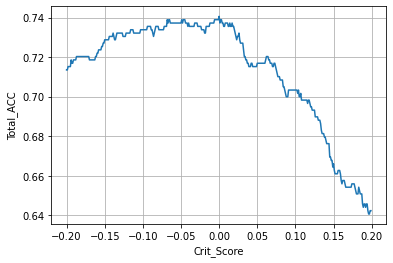

In [24]:
x= np.arange(-0.2,0.2,0.001)
y=accuaracy
plt.plot(x,y)
plt.xlabel('Crit_Score')
plt.ylabel('Total_ACC')
plt.grid()
plt.show()

# **위와 동일 조건에서 한글자 단어 제거, 한 단어 문장 제거 79~80%**

In [33]:
xls_path='/content/C01_KM_Data_Labeling_resized (1).xlsx'
news_copy = pd.read_excel(xls_path, header=5)

ksaa = KSAA()
title_pol_co=[]
for i in range(590):
    for k in news_copy['Title'][i].replace('...','').replace('..','').replace('.','').split(sep='.'):
        tokens= ksaa.tokenize(k)
        token_lst=[]  
        for a in tokens:
            one_dot=a.split('/')
            if len(one_dot[0])!=int(1):
                join_dot='/'.join(one_dot)
                token_lst.append(join_dot)
        if len(token_lst) < int(2):
            token_lst=[]
        score = ksaa.get_score(token_lst)
        title_pol_co.append(score['Polarity'])

#제목 극성 /2 = title_polr
title_polr_co=np.array(title_pol_co)/2
print(len(title_polr_co))

text_pol_co=[]
for i in range(590):
    polar=0
    for k in news_copy['Text'][i].split(sep='.'):
        tokens= ksaa.tokenize(k)
        token_lst=[]  
        for a in tokens:
            one_dot=a.split('/')
            if len(one_dot[0])!=int(1):
                join_dot='/'.join(one_dot)
                token_lst.append(join_dot)
        if len(token_lst) < int(2):
            token_lst=[]
        score = ksaa.get_score(token_lst)
        polar+=score['Polarity']
        sen_num=len(news_copy['Text'][i].split(sep='.'))
    text_pol_co.append(polar/sen_num)


text_polr_co=np.array(text_pol_co)*/2
total_polr_co=title_polr_co + text_polr_co
news_arr_co=np.array(news_copy['Sentiment'])
news_copy['title_polar_co']=title_polr_co
news_copy['text_polar_co']=text_polr_co
news_copy['total_polar_co']=total_polr_co




590


In [34]:
def polar_mean_co( polar_set):
    aa=news_copy[news_copy['Sentiment']==-1][f'{polar_set}']
    aaa=0
    # bb=news_set[news_set['Sentiment']==0][f'{polar_set}']
    # bbb=0
    cc=news_copy[news_copy['Sentiment']==1][f'{polar_set}']
    ccc=0
    for a in aa:
        aaa+=a

    # for b in bb:
    #     bbb+=b

    for c in cc:
        ccc+=c
    print(aaa/sum(news_copy['Sentiment']==-1), ccc/sum(news_copy['Sentiment']==1))
    print(sum(news_copy['Sentiment']==-1),sum(news_copy['Sentiment']==1))

In [35]:
polar_mean_co('title_polar_co')
polar_mean_co('text_polar_co')
polar_mean_co('total_polar_co')

0.004775278796817547 0.16955032952016186
178 412
0.07525937582875146 0.18119911713779613
178 412
0.080034654625569 0.3507494466579579
178 412


In [36]:
acc=[]
for x in np.arange(-0.2,0.2,0.001):
    result_a_co=[]
    for a in news_copy['total_polar_co']:    
        if a > x:
            result_a_co.append(1)
        else:
            result_a_co.append(-1)
    ac = np.sum(np.equal(news_copy['Sentiment'],result_a_co))/len(result_a_co)
    acc.append(ac)
    


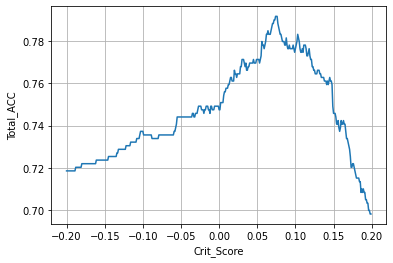

In [37]:
x= np.arange(-0.2,0.2,0.001)
y=acc
plt.plot(x,y)
plt.xlabel('Crit_Score')
plt.ylabel('Total_ACC')
plt.grid()
plt.show()

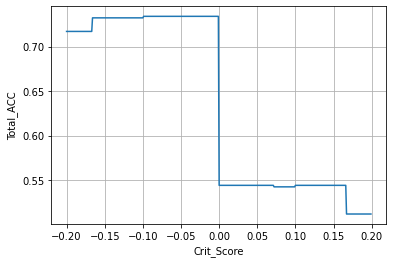

In [38]:
acc=[]
for x in np.arange(-0.2,0.2,0.001):
    result_a_co=[]
    for a in news_copy['title_polar_co']:    
        if a > x:
            result_a_co.append(1)
        else:
            result_a_co.append(-1)
    ac = np.sum(np.equal(news_copy['Sentiment'],result_a_co))/len(result_a_co)
    acc.append(ac)
x= np.arange(-0.2,0.2,0.001)
y=acc
plt.plot(x,y)
plt.xlabel('Crit_Score')
plt.ylabel('Total_ACC')
plt.grid()
plt.show()

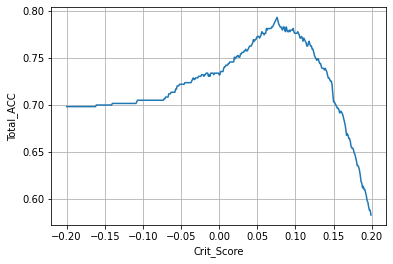

In [39]:
acc=[]
for x in np.arange(-0.2,0.2,0.001):
    result_a_co=[]
    for a in news_copy['text_polar_co']:    
        if a > x:
            result_a_co.append(1)
        else:
            result_a_co.append(-1)
    ac = np.sum(np.equal(news_copy['Sentiment'],result_a_co))/len(result_a_co)
    acc.append(ac)
x= np.arange(-0.2,0.2,0.001)
y=acc
plt.plot(x,y)
plt.xlabel('Crit_Score')
plt.ylabel('Total_ACC')
plt.grid()
plt.show()

# **text_polar와 title_polar의 가중치 조절을 통한 예측 80~81%**

In [76]:
title_polr_co_ree=np.array(title_pol_co)*0.2
text_polr_co_ree=np.array(text_pol_co)*0.8
total_polr_co_ree=title_polr_co_ree + text_polr_co_ree
news_copy['total_polar_co_ree']=total_polr_co_ree

In [77]:
polar_mean_co('total_polar_co_ree')

0.12232511284472937 0.3577387192285384
178 412


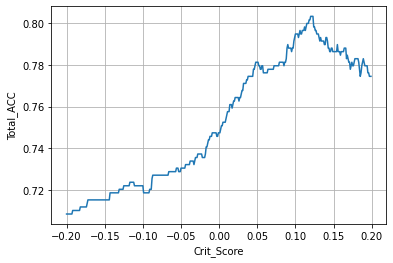

In [78]:
acc=[]
for x in np.arange(-0.2,0.2,0.001):
    result_a_co_ree=[]
    for a in news_copy['total_polar_co_ree']:    
        if a > x:
            result_a_co_ree.append(1)
        else:
            result_a_co_ree.append(-1)
    ac = np.sum(np.equal(news_copy['Sentiment'],result_a_co_ree))/len(result_a_co_ree)
    acc.append(ac)

x= np.arange(-0.2,0.2,0.001)
y=acc
plt.plot(x,y)
plt.xlabel('Crit_Score')
plt.ylabel('Total_ACC')
plt.grid()
plt.show()

## 기사 수가 적은 날은 중립으로 보고 제외 시킨 뒤 , 
# **나머지 기사를 가지고 감정분석을 통해 긍정, 부정 나누기.** 

In [79]:
date_polar = pd.read_excel('/content/C01-1_KM_Data_LabelingResult_incl_resize.xlsx')

In [82]:
date_sent=date_polar[['Date','S']]

In [85]:
date_sent.to_csv('date_sent.csv',mode='w')

In [ ]:
date_pos=0
date_neg=0
date_neu=0